In [1]:
from utils.mf_stats_analysis import *

# __<font color='blue'>Bosch Manufacturing</font>__

# __<font color='darkblue'> Part 2: Statistical Analysis</font>__

------

__Author:__ [Ryan Harper](www.kimrharper.com) <br><br>
__Data Source:__ [Bosch Dataset via Kaggle](https://www.kaggle.com/c/bosch-production-line-performance/data) <br> <br>
__Background:__ Bosch is a home appliance and industrial tools manufacturing company. In 2017, Bosch supplied Kaggle.com with manufacturing data to promote a competition. The goal of the competition was to determine factors that influence whether or not the product passes the final response stage of manufacturing and to predict which products are likely to fail based on this manufacturing process.<br> <br>
__The Data:__ Early exploration of this data will use a subset of the big data provided by Bosch. The data is provided by [Hitesh, John, and Matthew via PDX Data Science Meetup](https://www.meetup.com/Portland-Data-Science-Group/events/257370691/). The data subset is divided into 2 groups of 3 files (3 training, 3 test). Each group has one csv file each for numerical features ('numeric'), dates ('date'), and the manufacturing path ('cat'). The data subset includes a larger percentage of products that failed the response test, but not much more is known about this subsampling method.<br><br>
__Assumptions:__ ID # represents a specific product and that there is only one product. The differences in assembly are due to customization and/or differences between lines.<br><br>
__Goal:__ Predict which products will fail the response test. <br>

------

# __1. <font color='darkblue'>Significance Testing</font>__

In [2]:
sig_diff_list = []
for i, c in enumerate(mf_num_data.columns):
    vals = sample_test(mf_num_data,i,ks_2samp, .1)
    if vals[1] == 'Different':
        sig_diff_list.append(i)

In [3]:
print(len(sig_diff_list))

401


401 out of 968 columns were selected using the ks_2amp test with using an initial threshold.

# __2. <font color='darkblue'>Distributions</font>__

In [4]:
mf_num_data.head()

Id  L0_S0_F0  L0_S0_F2  L0_S0_F4  L0_S0_F6  L0_S0_F8  L0_S0_F10  L0_S0_F12  \
0  23       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
1  71    -0.167    -0.168     0.276     0.330     0.074      0.161      0.052   
2  76       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
3  86    -0.003     0.041    -0.033    -0.016     0.074      0.161      0.000   
4  97       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

   L0_S0_F14  L0_S0_F16    ...     L3_S50_F4245  L3_S50_F4247  L3_S50_F4249  \
0        NaN        NaN    ...              NaN           NaN           NaN   
1      0.248      0.163    ...              NaN           NaN           NaN   
2        NaN        NaN    ...              NaN           NaN           NaN   
3     -0.072      0.025    ...              NaN           NaN           NaN   
4        NaN        NaN    ...              NaN           NaN           NaN   

   L3_S50_F4251  L3_S50_F4253  L3_S51_F4256  L3_S51_F4258  L3_S51_F4260  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   L3_S51_F4262  Response  
0           NaN       0.0  
1           NaN       0.0  
2           NaN       0.0  
3           NaN       0.0  
4           NaN       0.0  

[5 rows x 970 columns]

In [5]:
def get_skewed_group(s):
    ds = describe(s)
    if (ds.skewness < -1 or ds.skewness > 1) and (ds.kurtosis < 5 or ds.kurtosis < -5) :
        return True
    else:
        return False  

In [6]:
def get_4_values(s):
    ds = describe(s)
    return ('Mean: {} \n Variance: {}\nSkewness: {}\n Kurtosis: {}\n'.format(ds.mean, ds.variance, ds.skewness, ds.kurtosis ))

In [7]:
s_transformed = pt.fit_transform(mf_num_data)

In [8]:
# Function for different viz of distributions
def plot_dist(df, col_index, transformed):
    c = df.columns[col_index]
    normed = distribution_assignment(df[c])
    summary_statistics = get_4_values(df[c].dropna().values)
    s_3 = df[c][np.abs(df[c]-df[c].mean()) <= (3*df[c].std())] # Keep inner 99.7 % of the Data
    s_1 = df[c][np.abs(df[c]-df[c].mean()) <= (1*df[c].std())] # Keep inner 68% of the Data
    transformed = transformed[~np.isnan(transformed)]          # Show the complete transformation of mf_num_data
    
    plt.figure(figsize=(20,1))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
    
    plt.subplot(1, 3, 1)
    plt.title('Feature: {}\n {} \nDistribution: {}\n\nOriginal\nSample Count: {}'.format(c,summary_statistics, normed,len(df[c].dropna())))
    sns.distplot(df[c].dropna(),color='blue')
    plt.xlabel('')

    s_success = df[c][df['Response']==0].dropna()
    s_failure = df[c][df['Response']==1].dropna()
    sampling_results = sample_test(df,col_index, ks_2samp,.1)
    
    plt.subplot(1, 3, 2)
    sns.distplot(s_success)
    plt.xlabel('')
    
    plt.subplot(1, 3, 2)
    plt.title('Success/Failure\n\n{}\nSuccess Count: {}\nFailure Count: {}'.format(sampling_results,len(s_success),len(s_failure)))
    sns.distplot(s_failure,color='purple')
    plt.xlabel('')
    plt.legend(['Success','Failure'])
    
    plt.subplot(1, 3, 3)
    plt.title('Transformed'.format(transformed,len(s_success),len(s_failure)))
    sns.distplot(s_failure,color='purple')
    plt.xlabel('')
    

In [26]:
features = mf_num_data.columns
skewed = [i for i in range(len(mf_num_data.columns)) if get_skewed_group(mf_num_data[features[i]].dropna())]
skewed_features = [features[i] for i in skewed]

In [28]:
%store skewed_features

Stored 'skewed_features' (list)


In [22]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 2000)

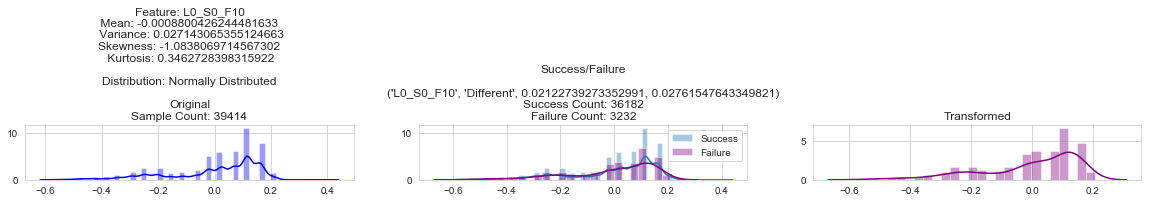

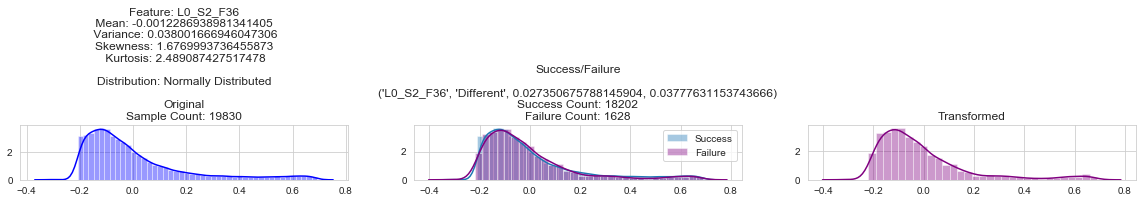

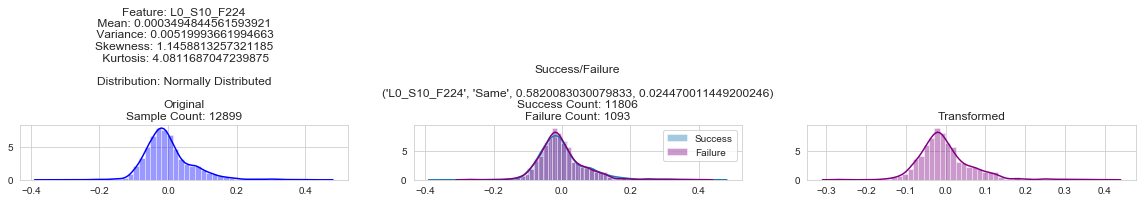

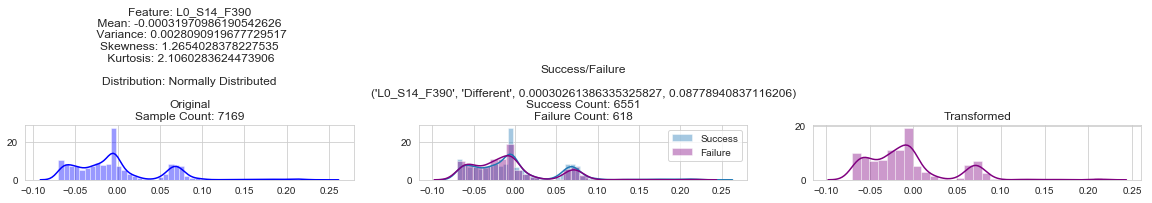

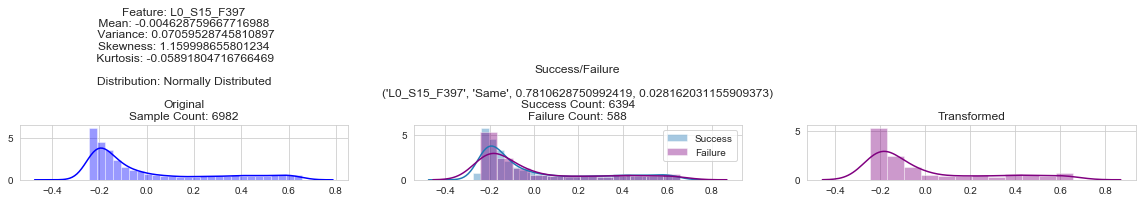

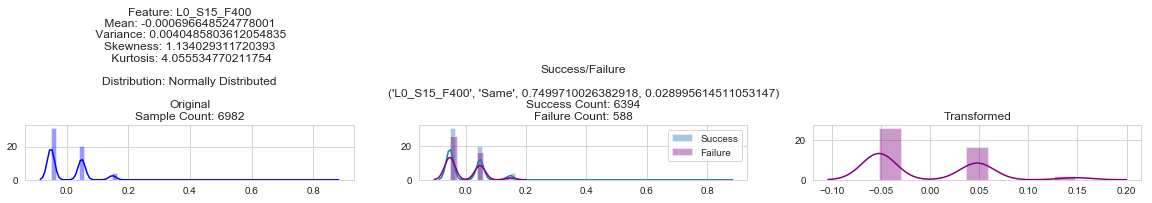

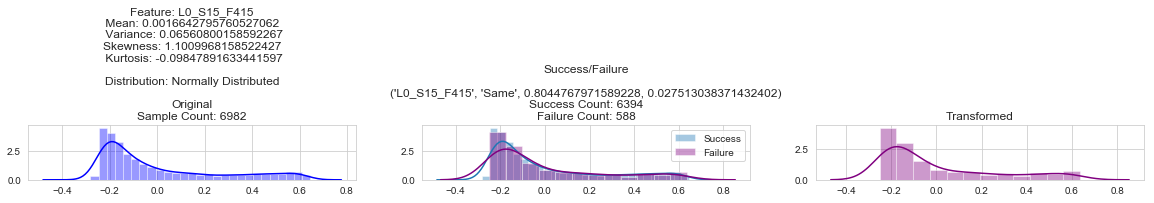

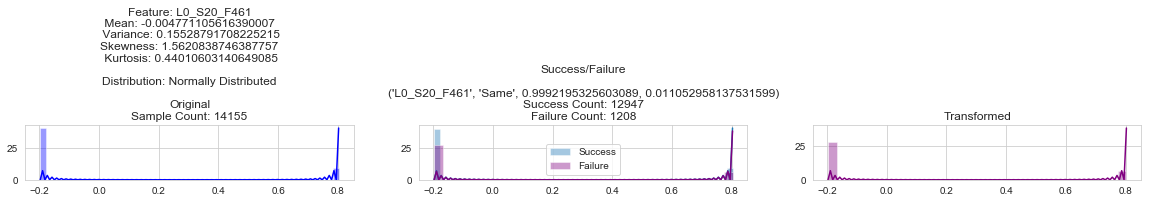

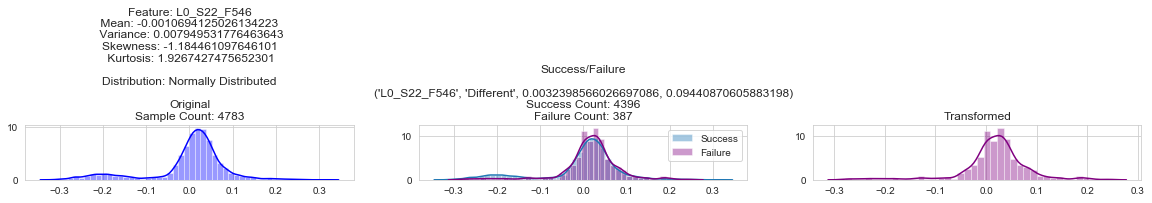

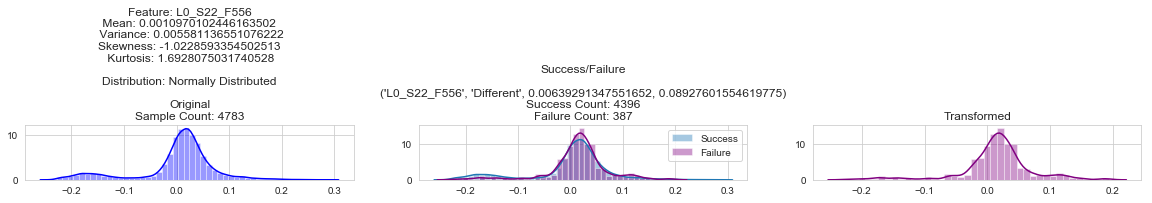

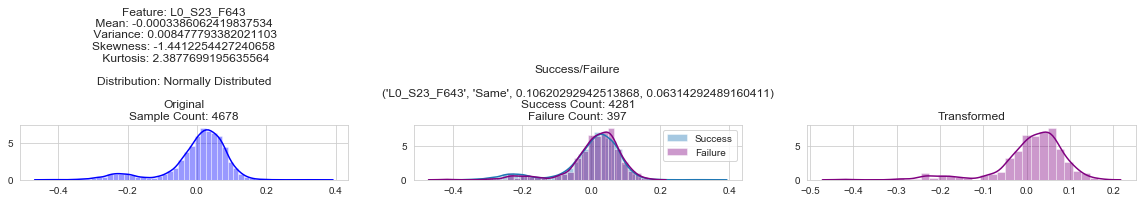

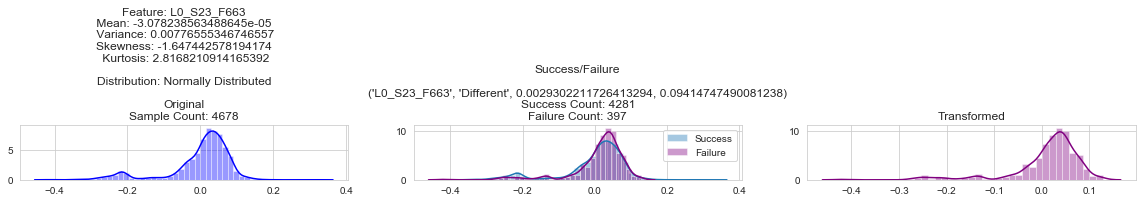

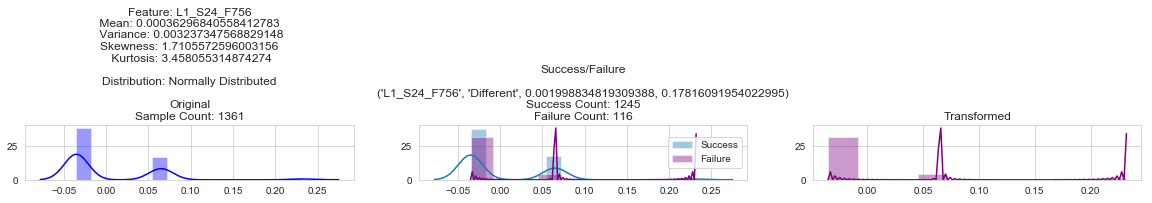

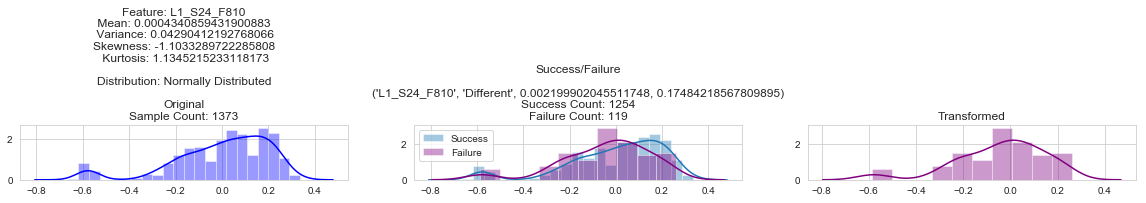

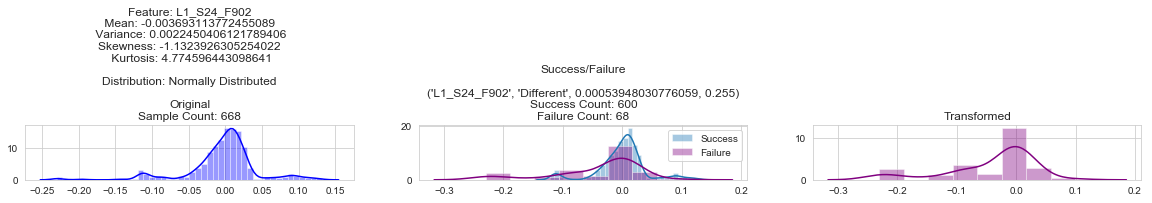

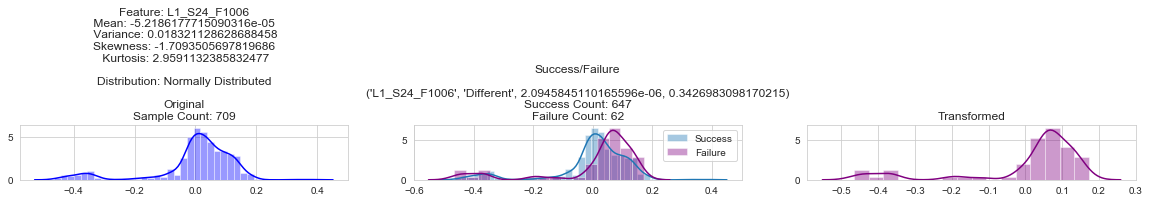

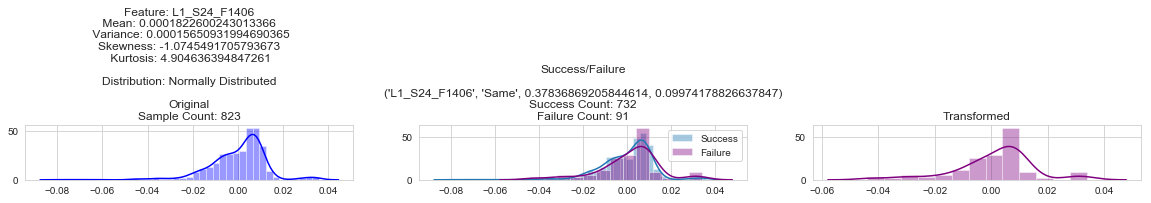

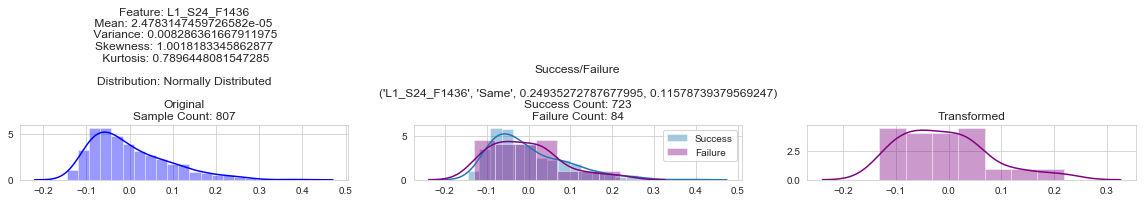

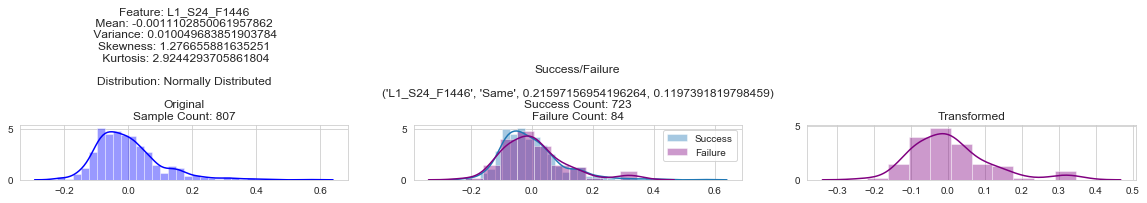

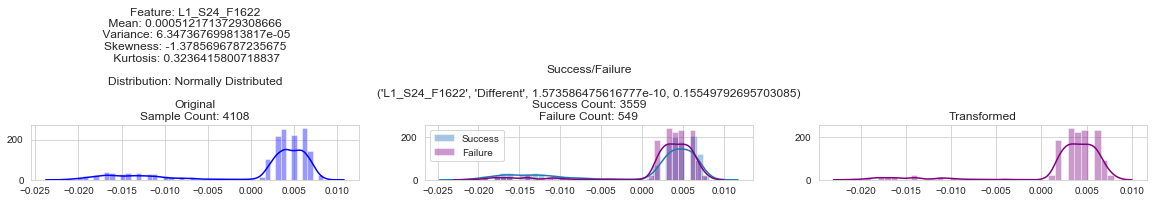

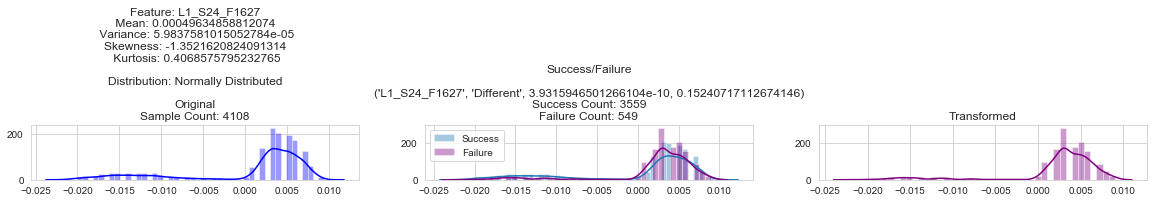

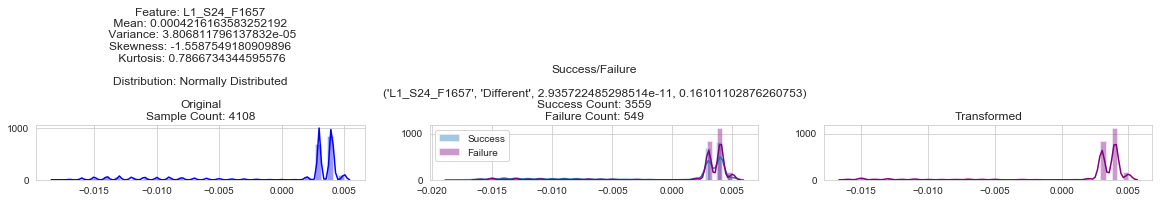

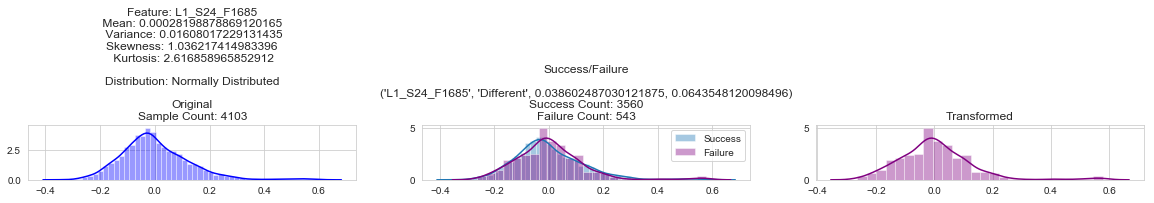

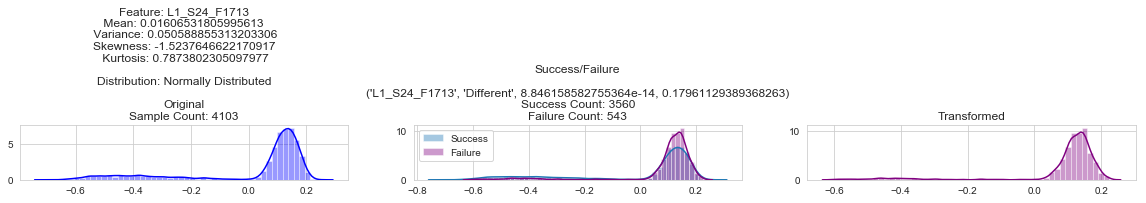

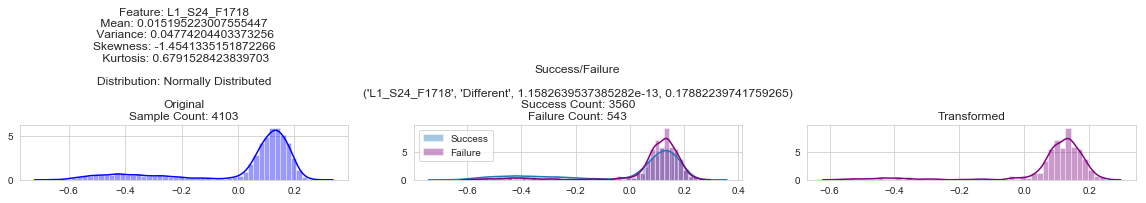

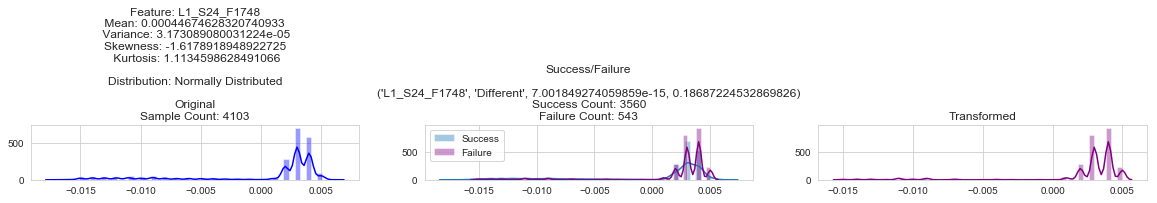

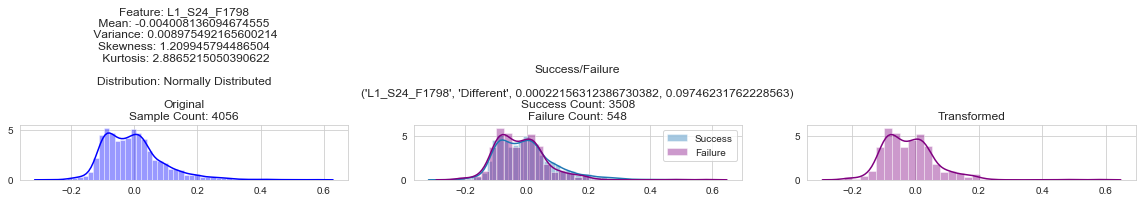

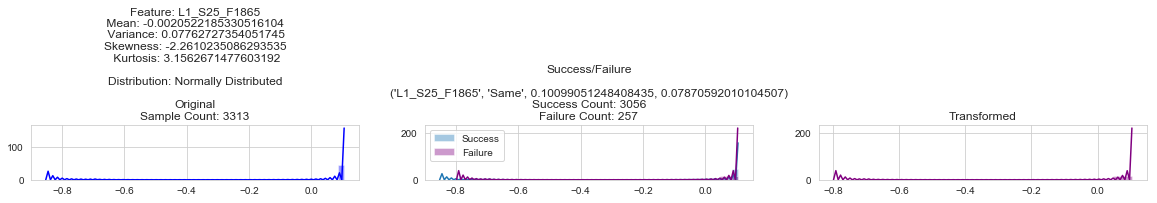

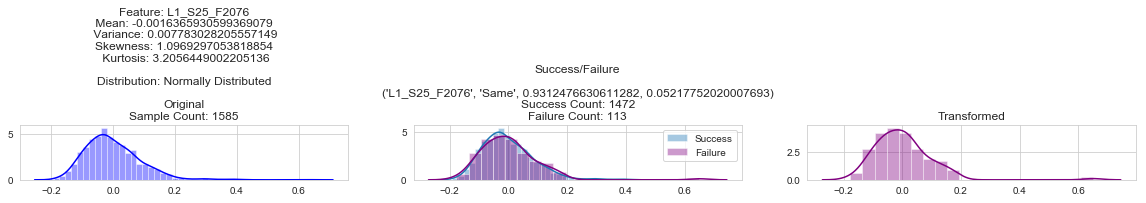

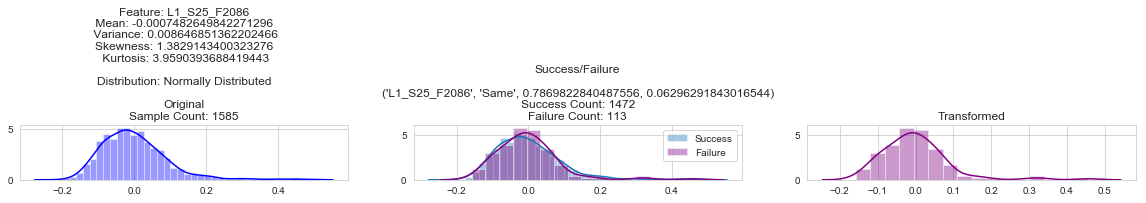

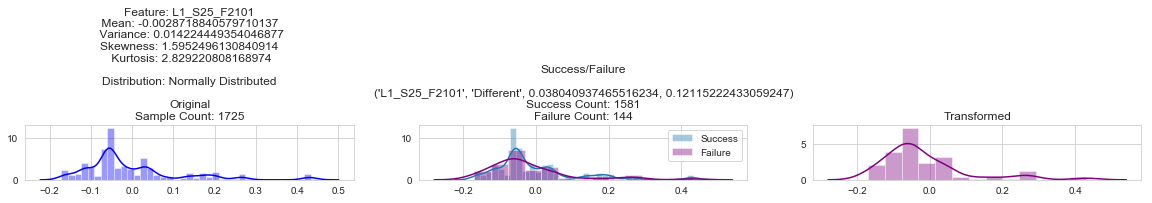

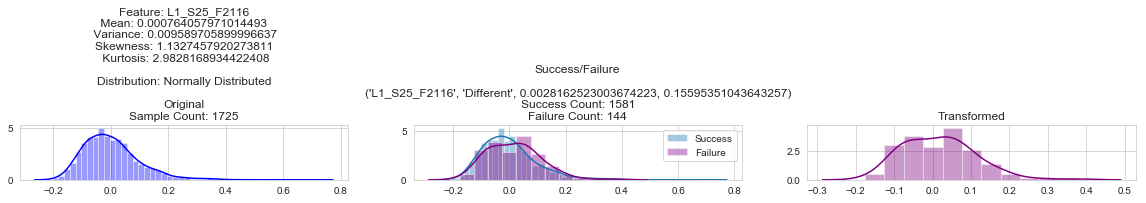

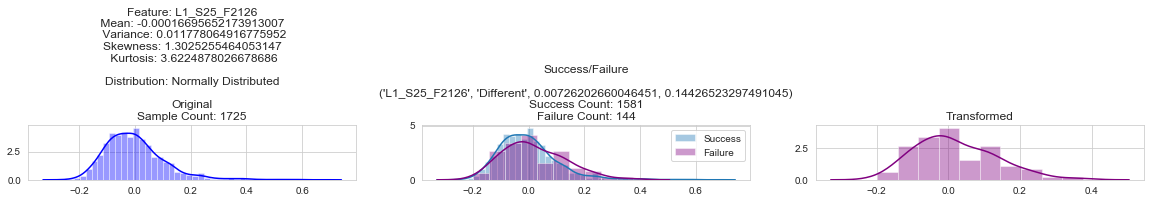

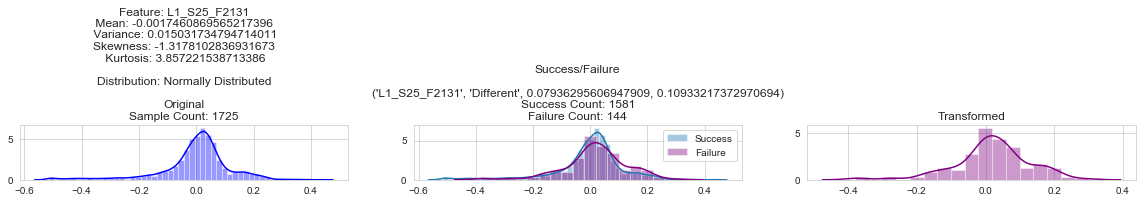

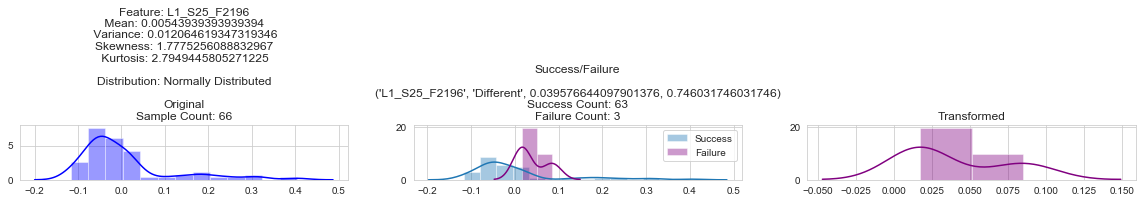

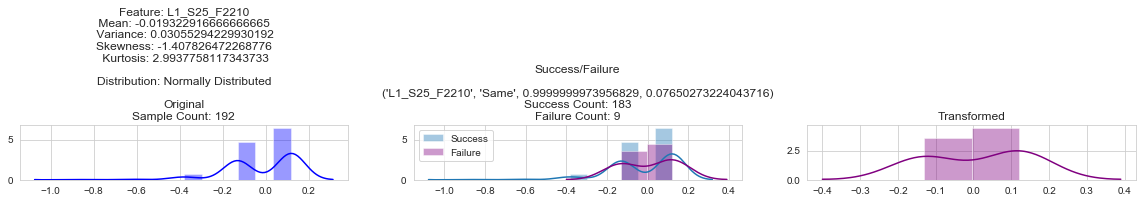

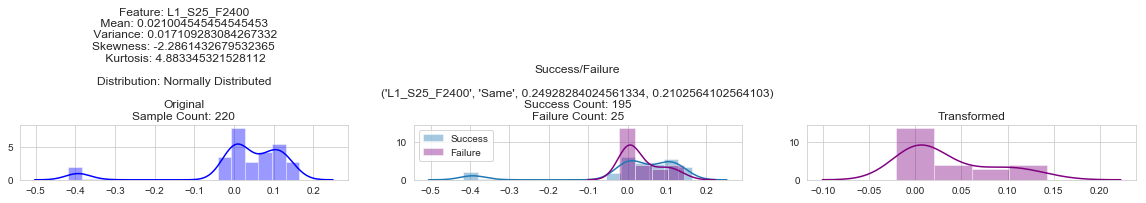

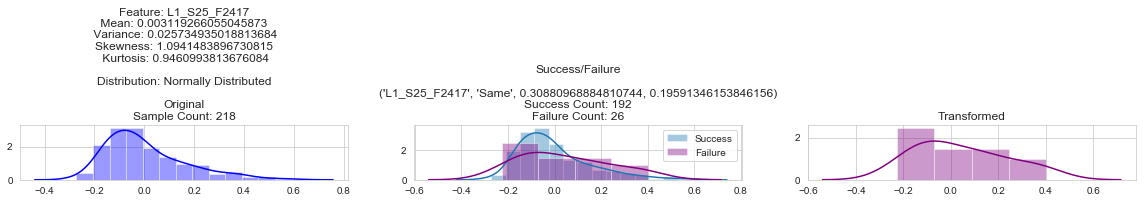

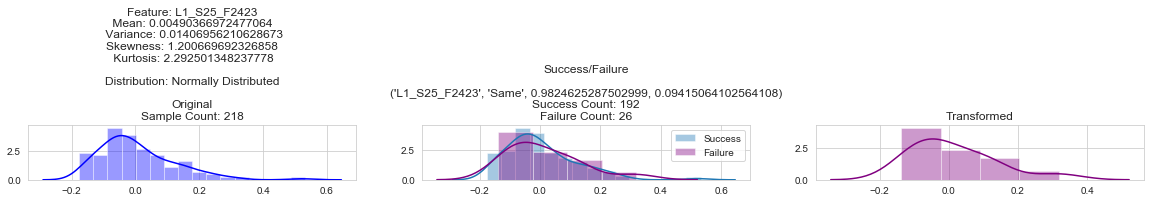

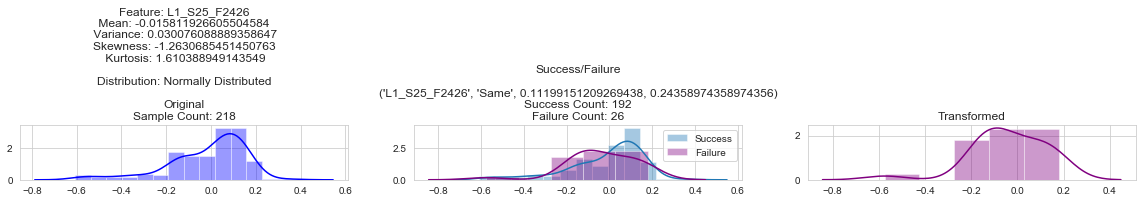

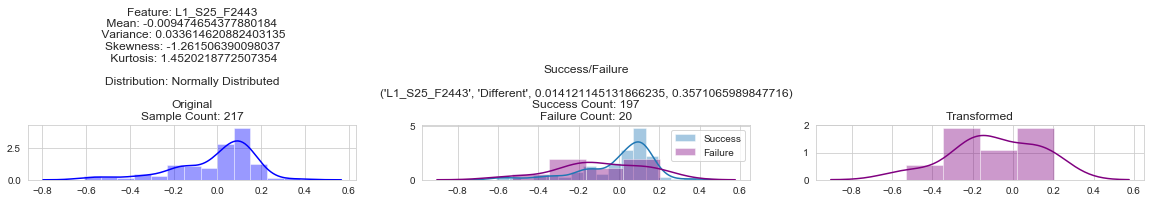

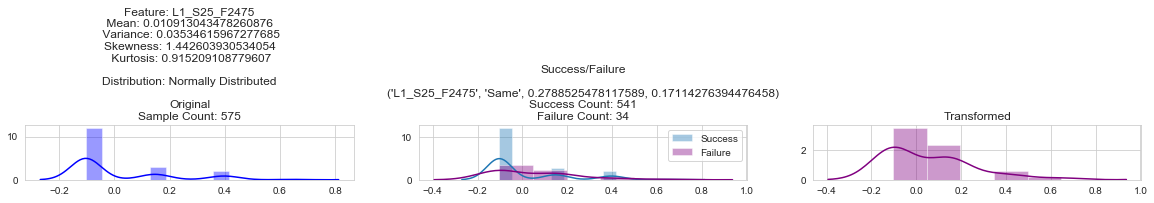

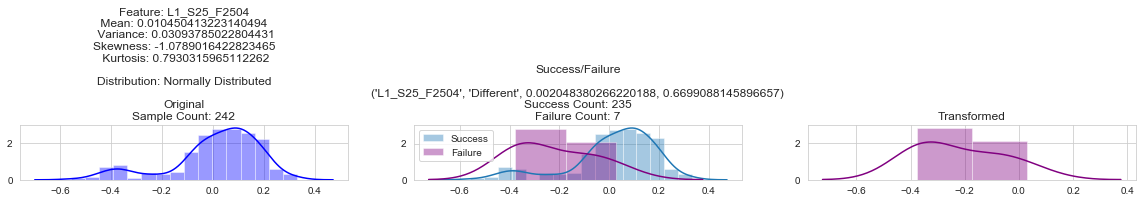

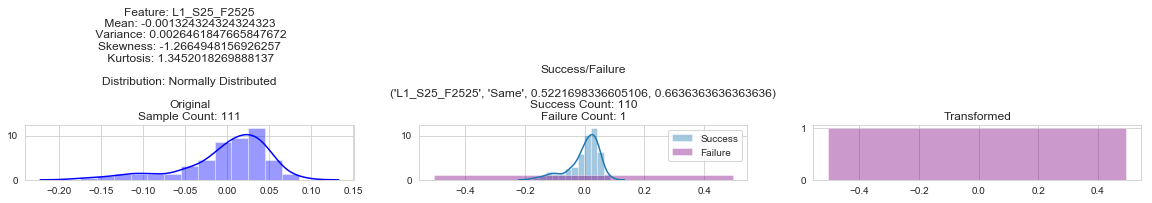

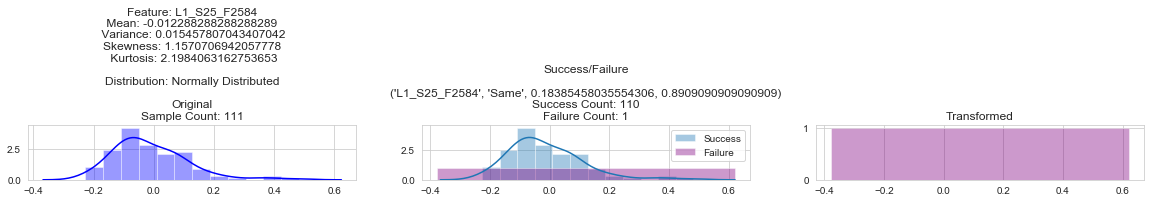

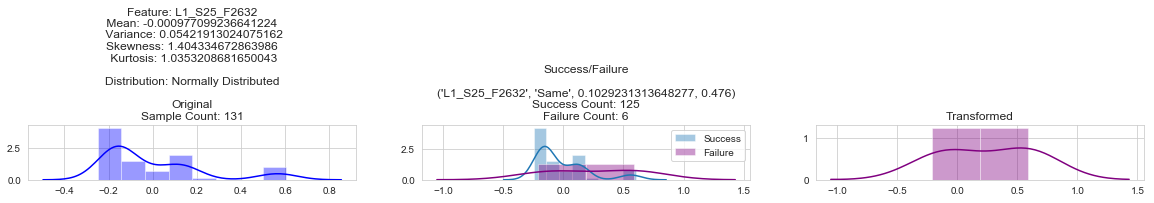

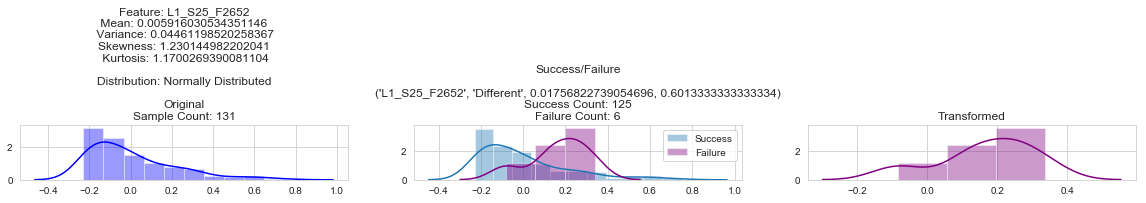

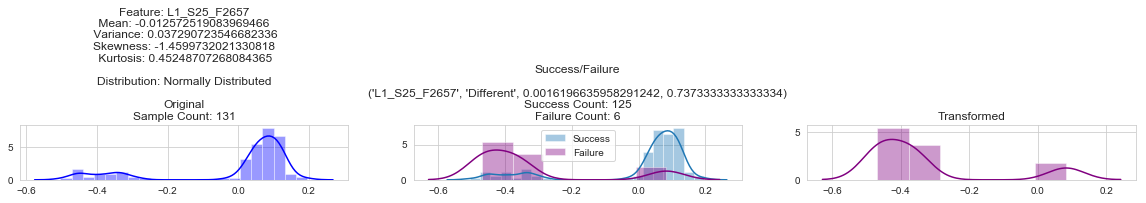

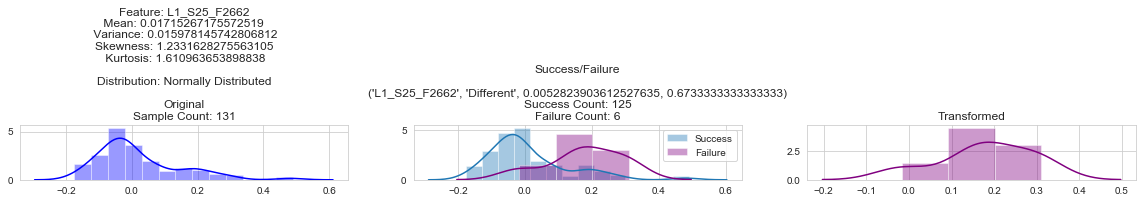

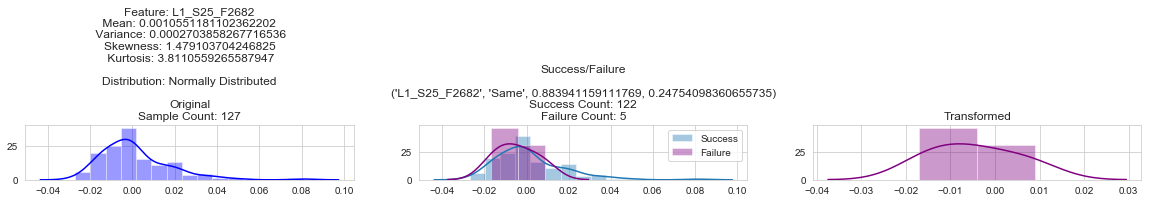

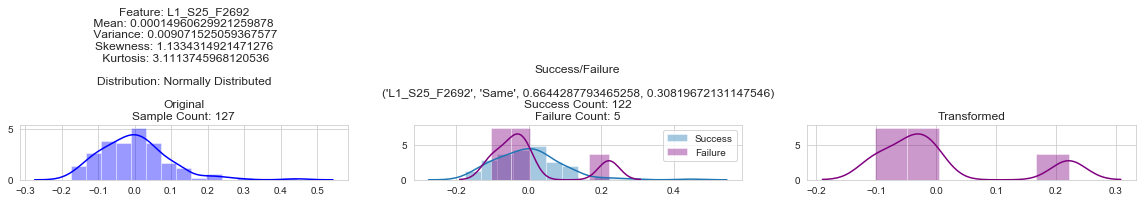

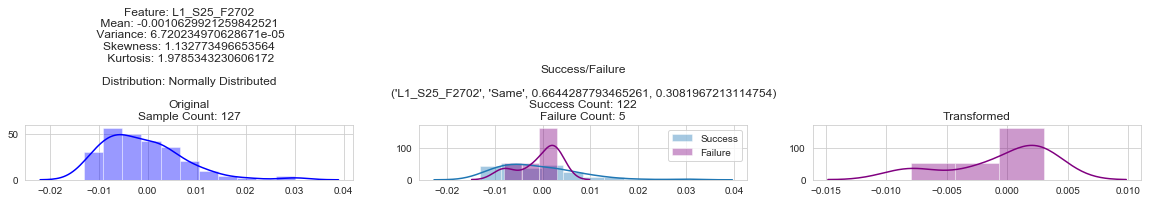

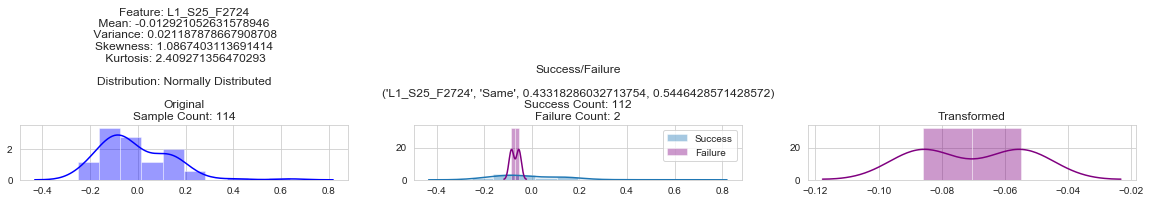

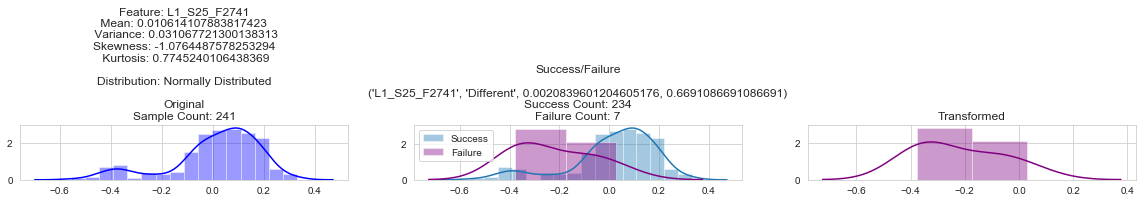

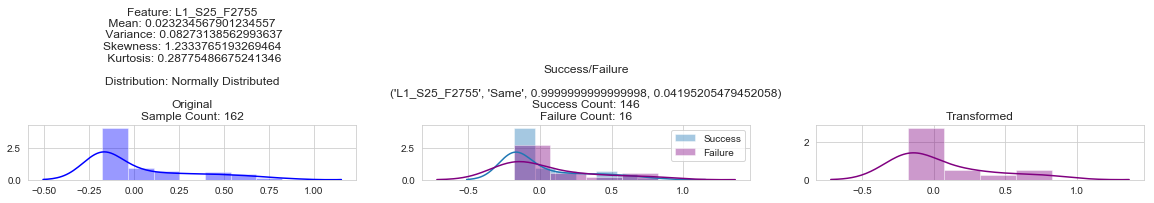

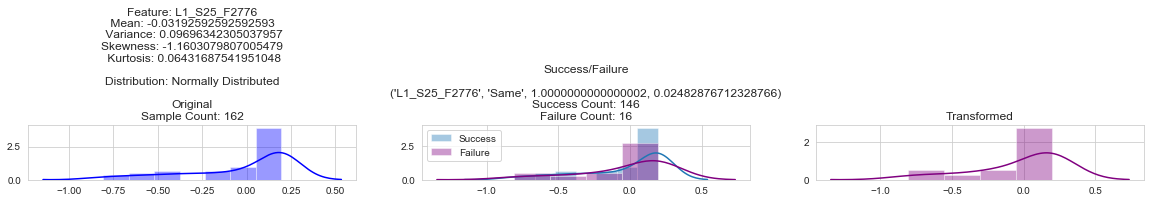

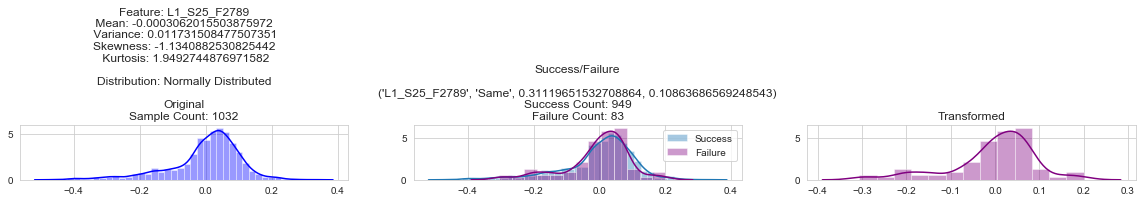

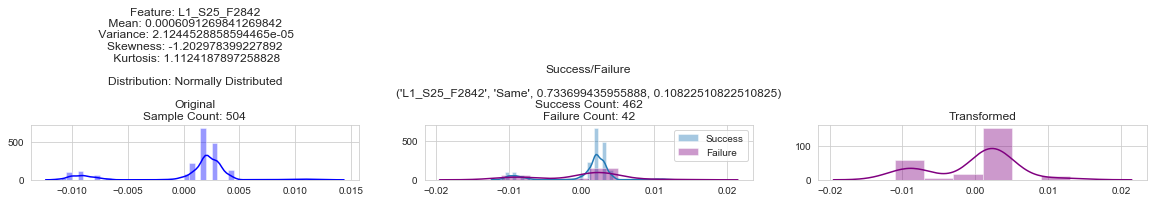

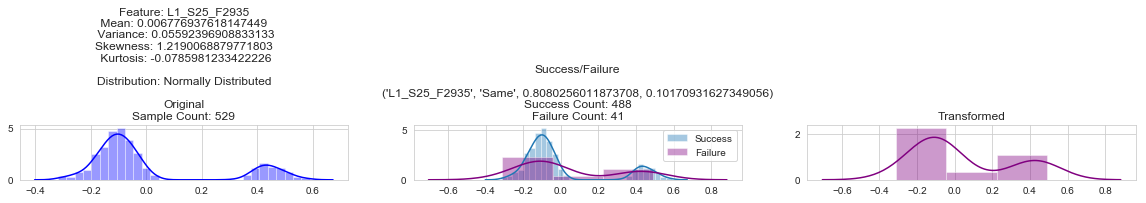

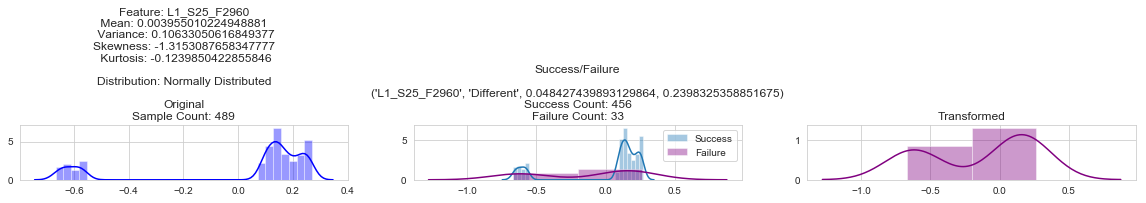

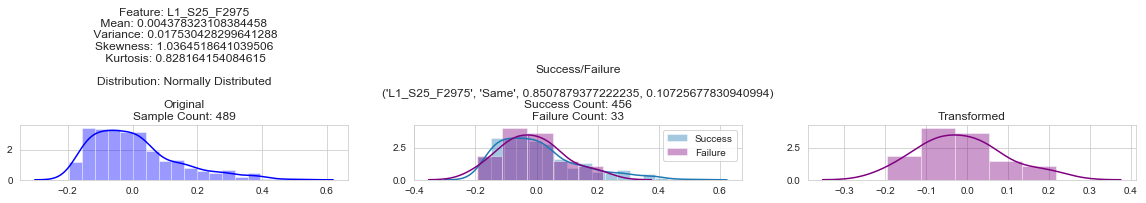

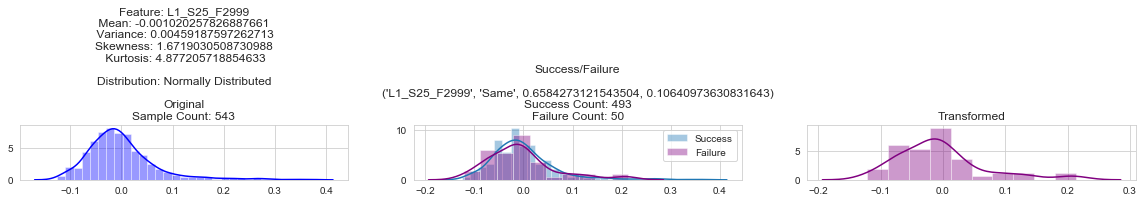

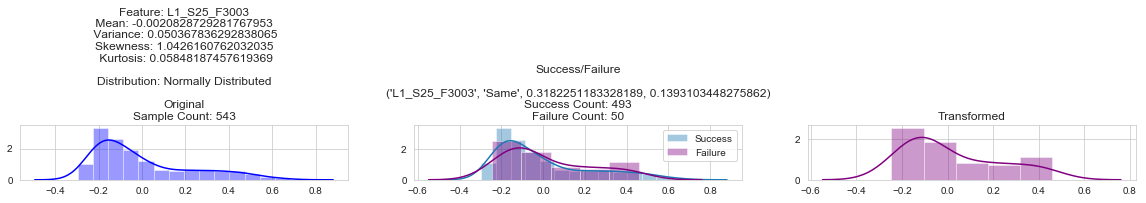

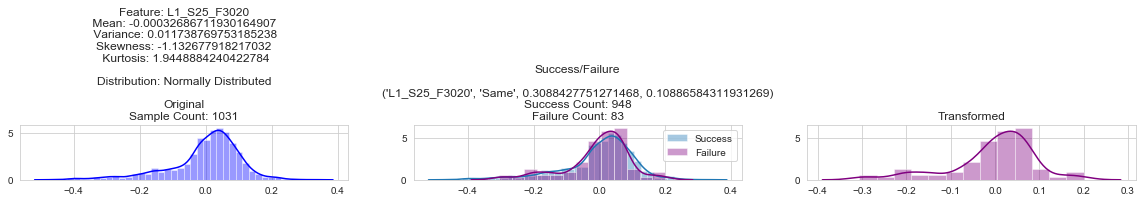

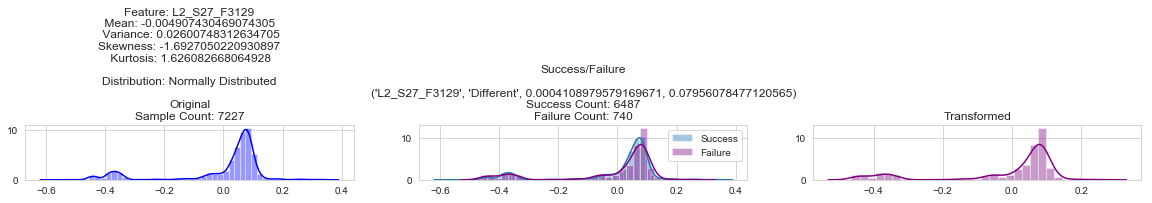

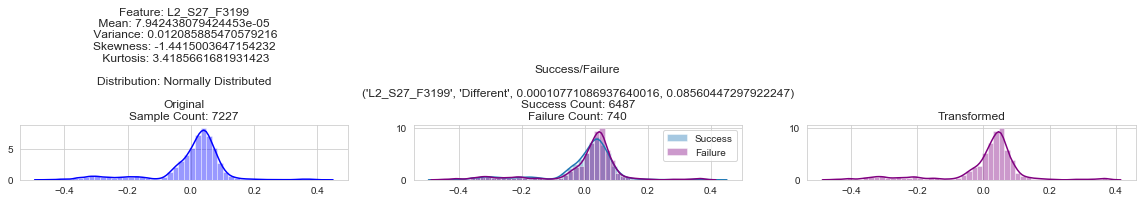

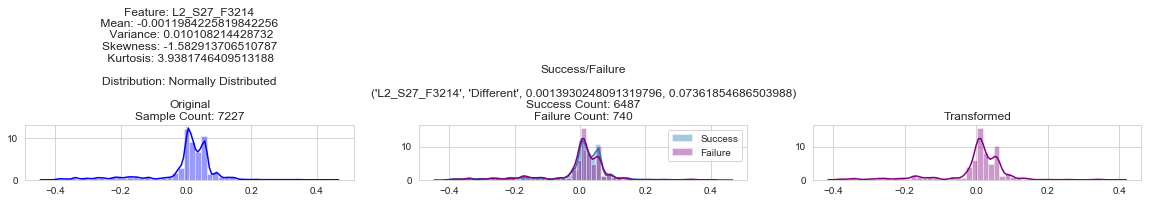

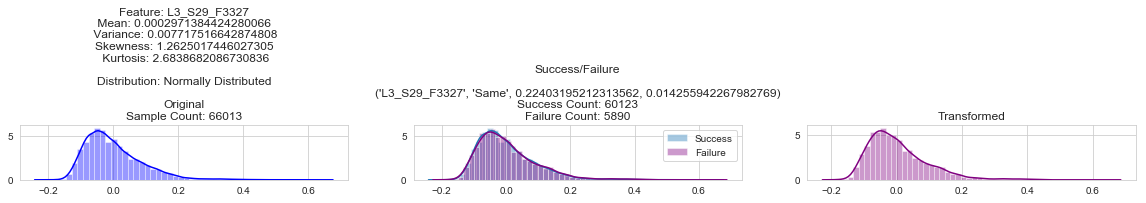

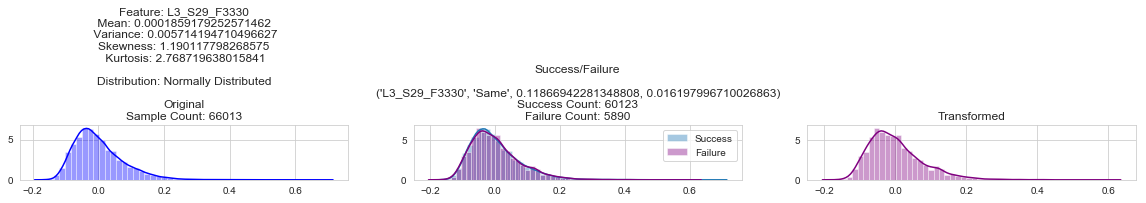

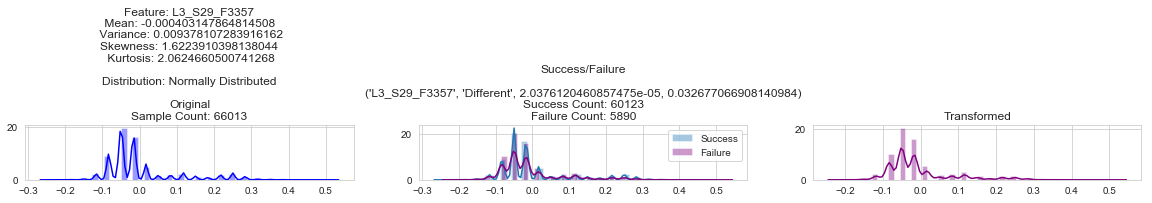

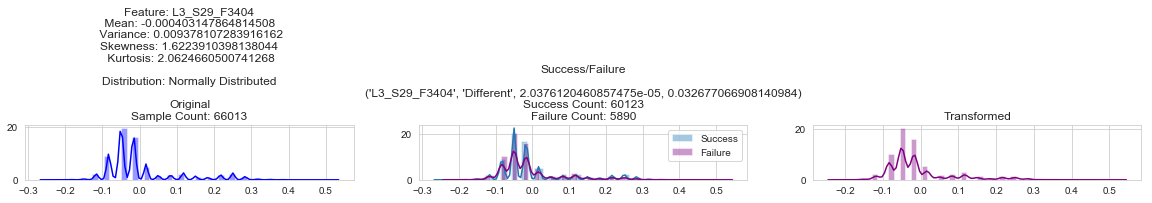

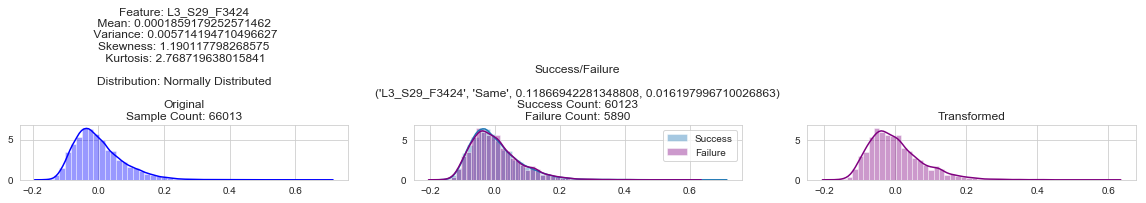

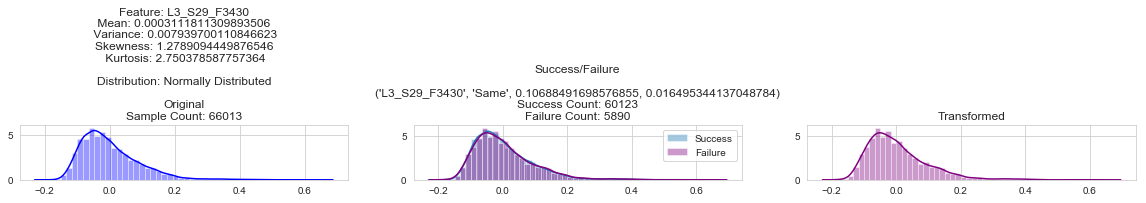

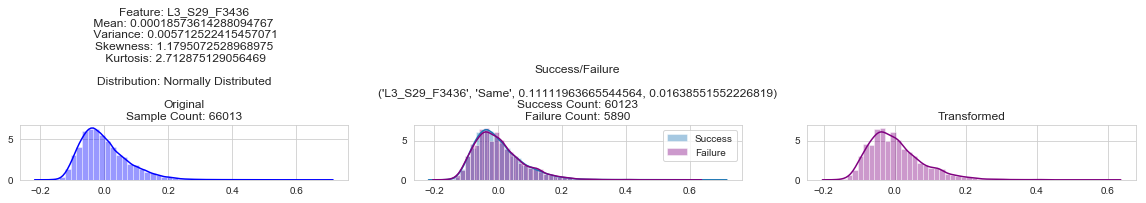

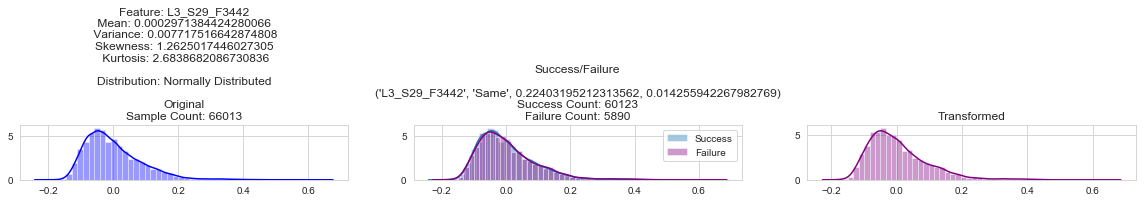

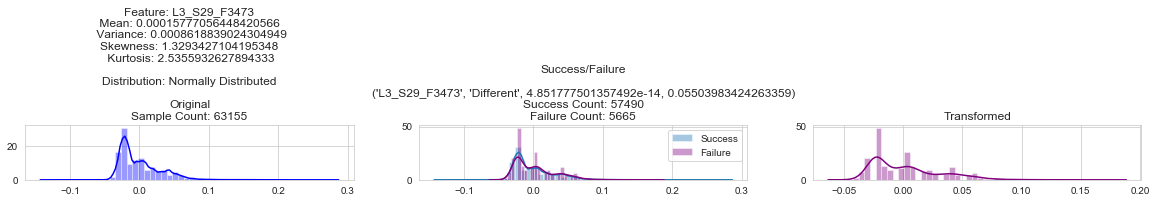

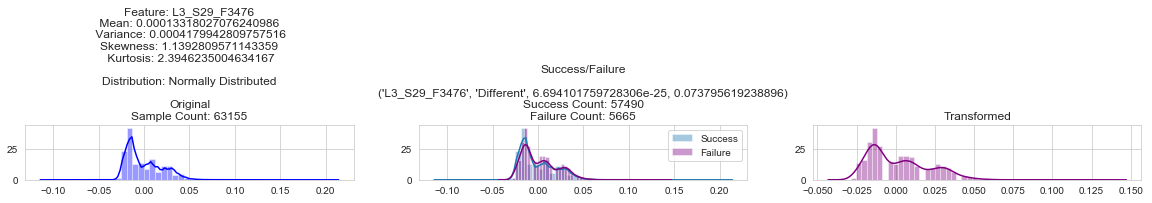

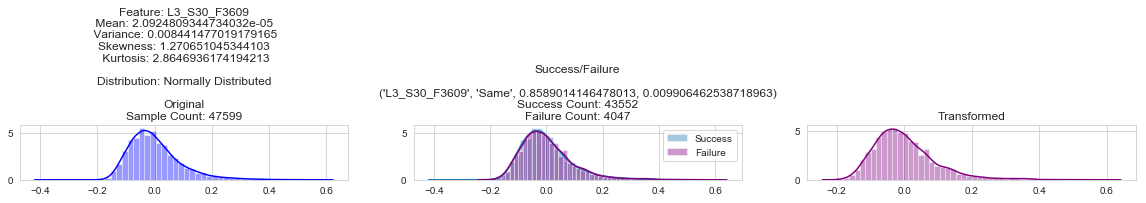

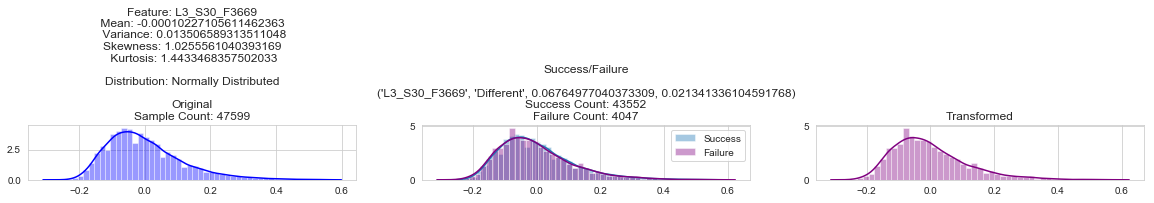

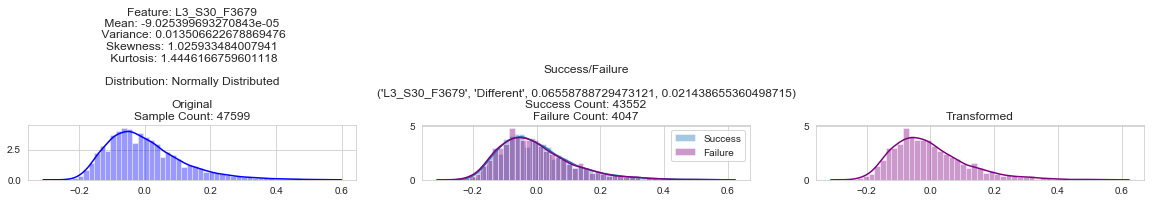

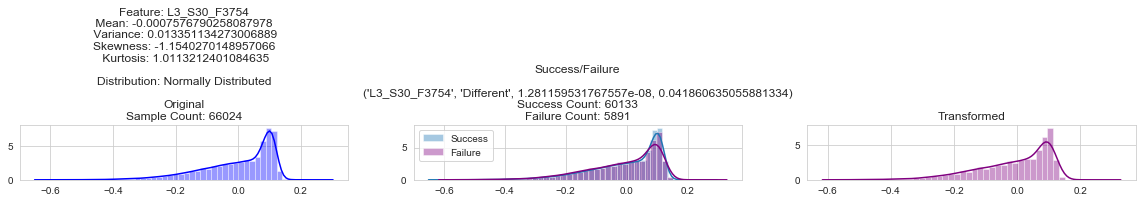

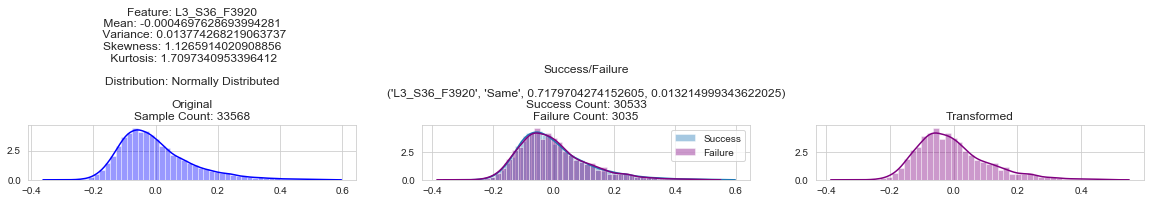

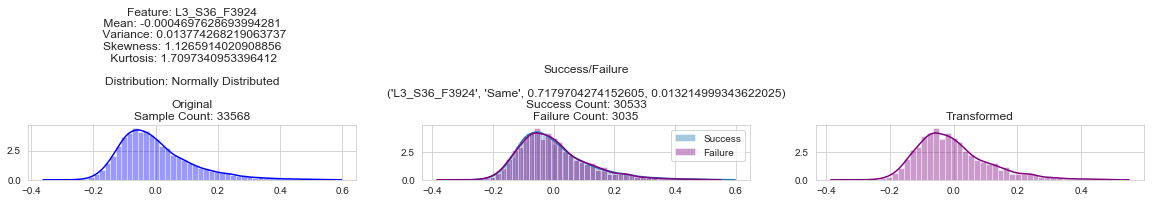

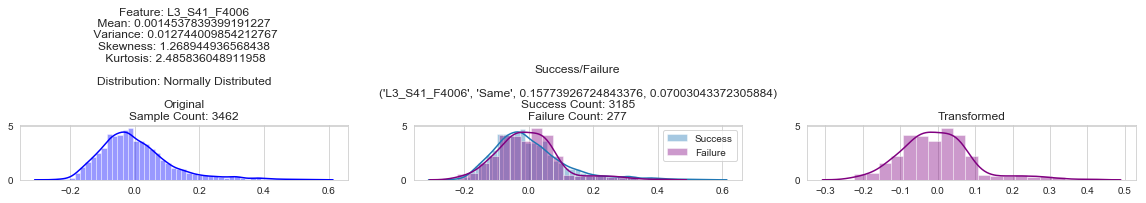

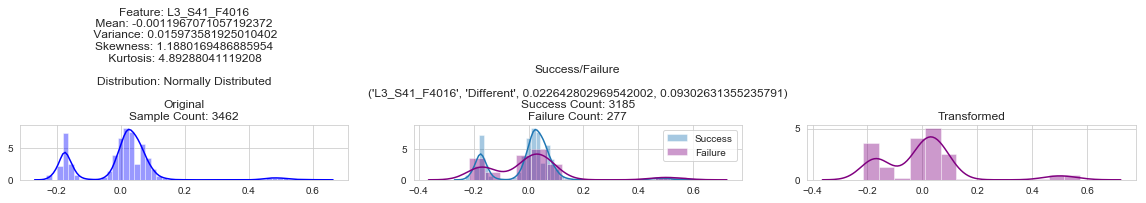

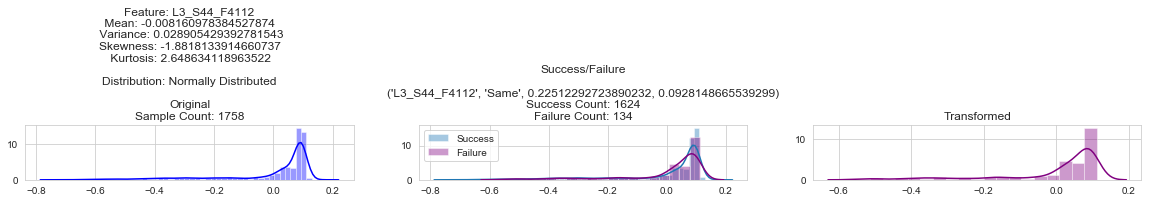

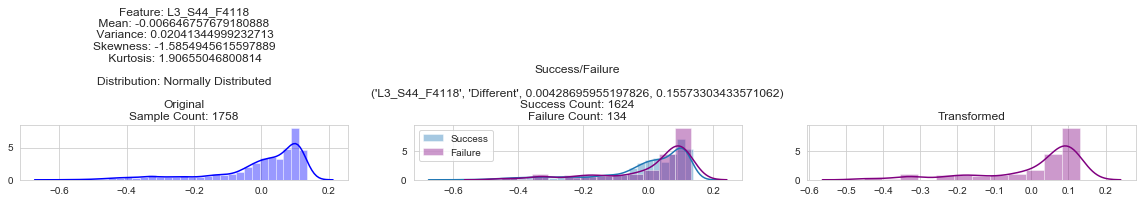

In [11]:
[plot_dist(mf_num_data,i,np.log(1+mf_num_data[features[i]].dropna())) for i in skewed];

## -----

## -----

## -----

## -----

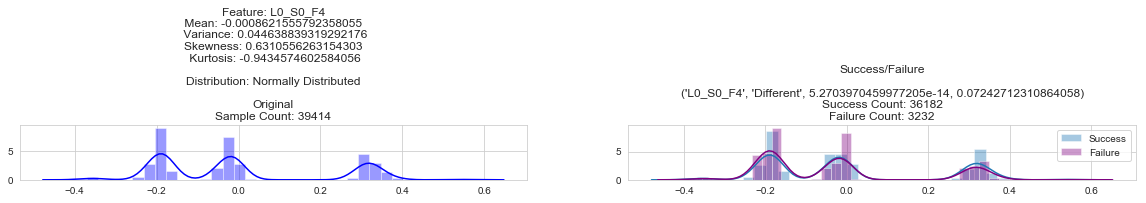

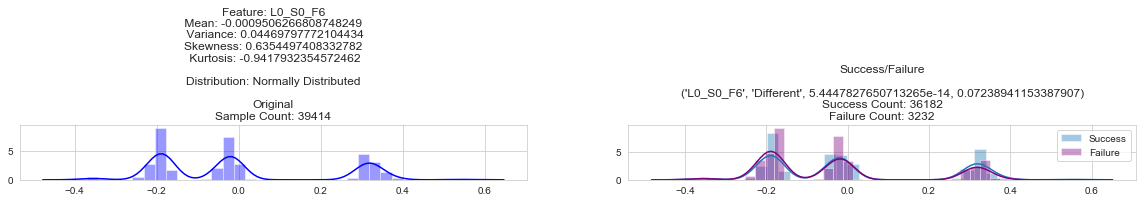

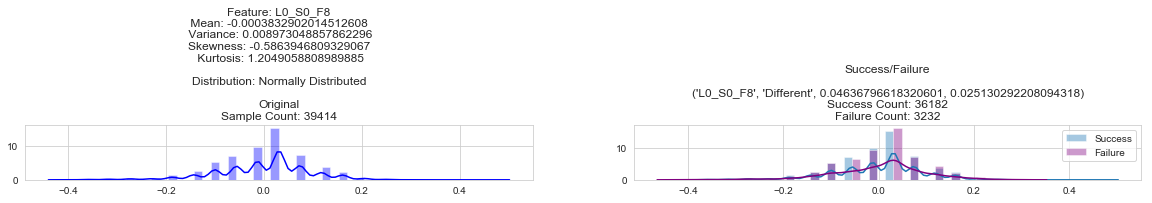

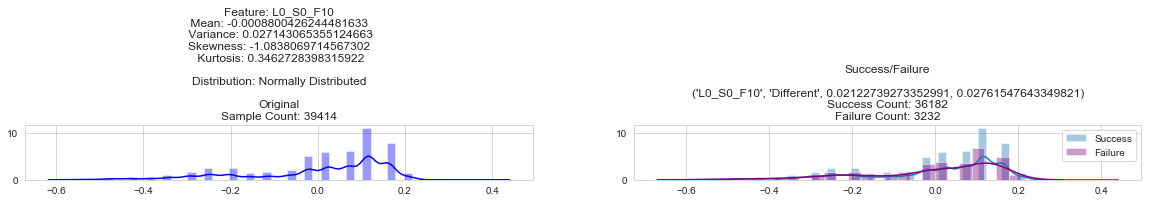

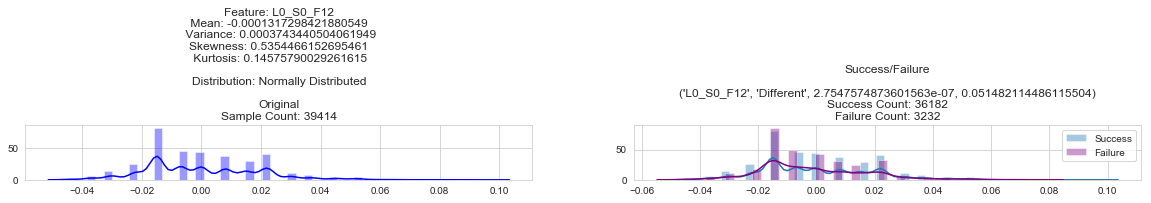

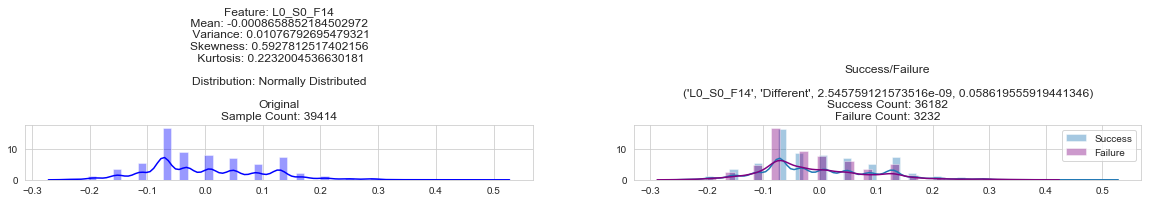

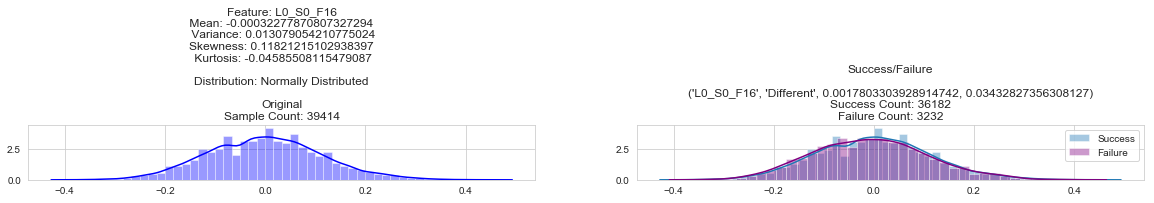

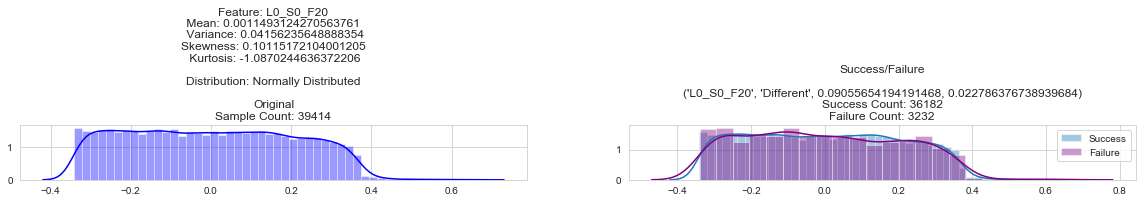

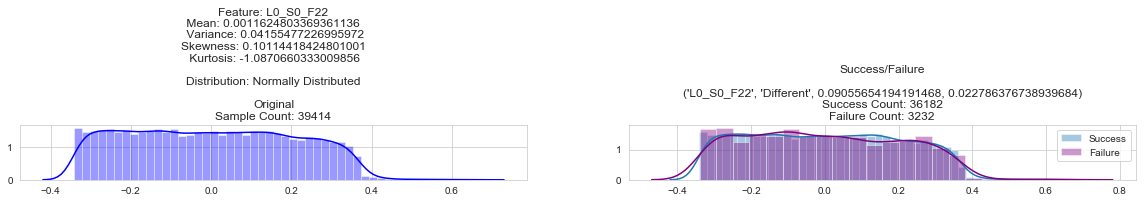

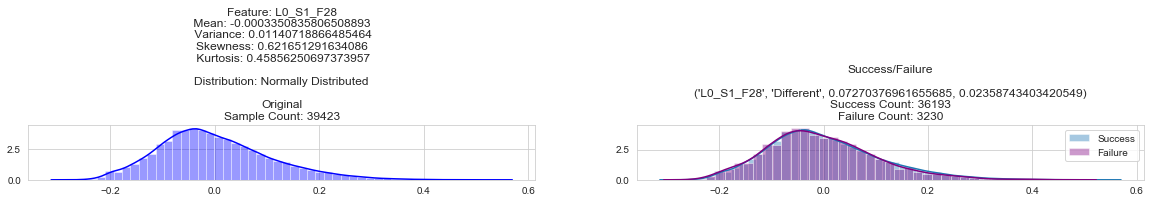

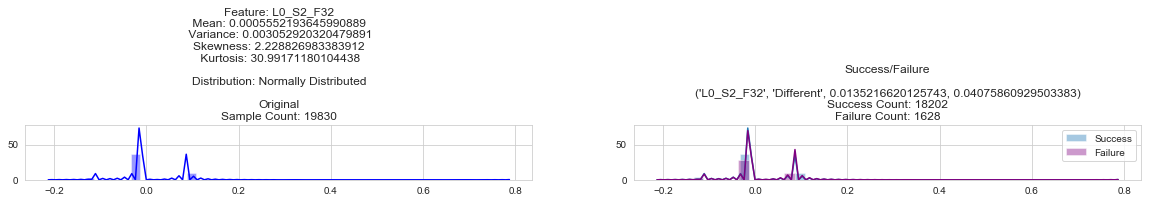

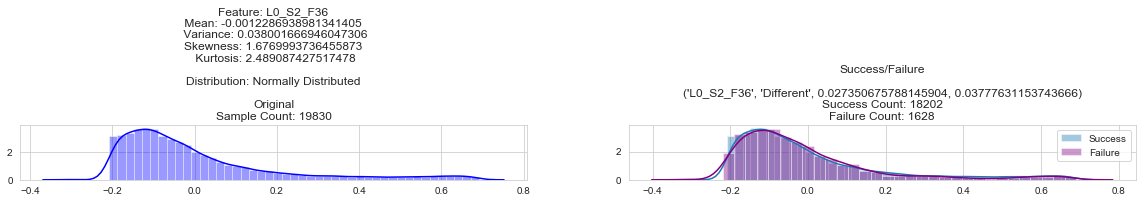

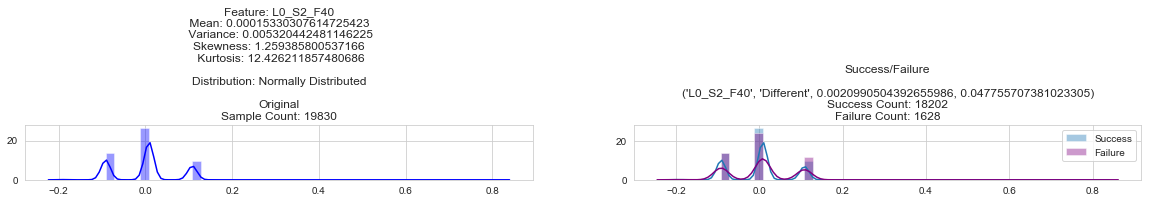

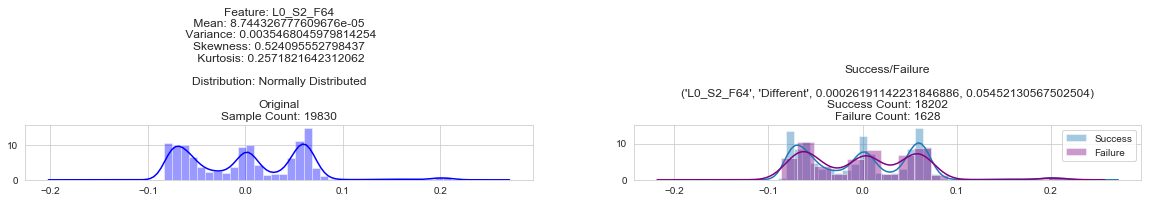

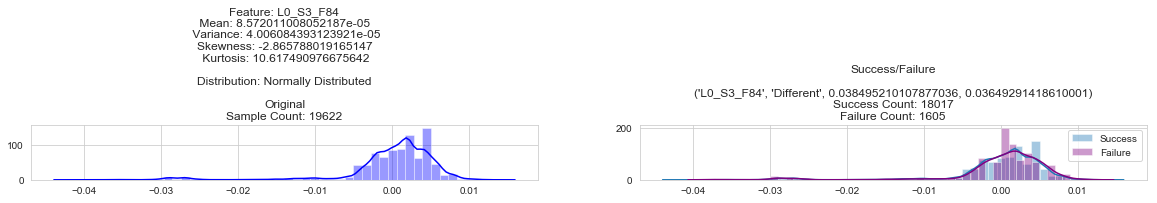

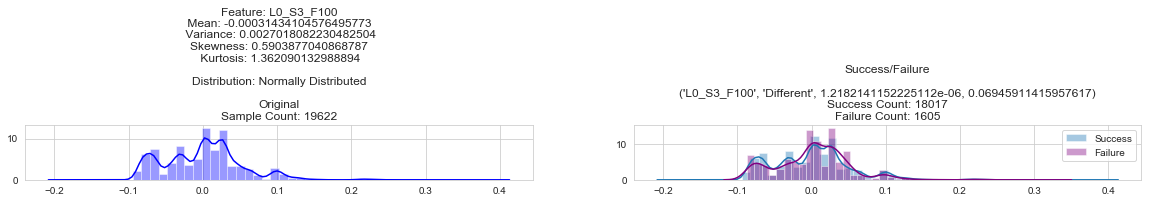

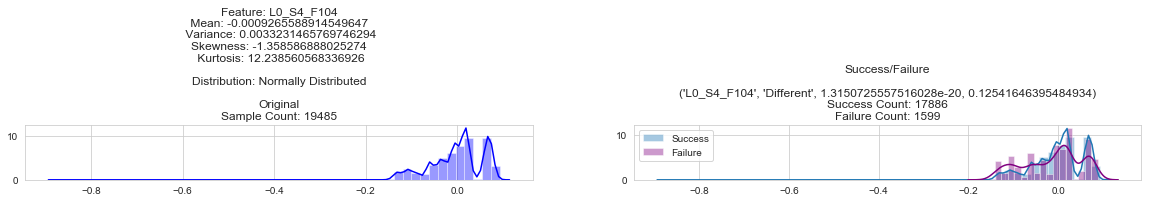

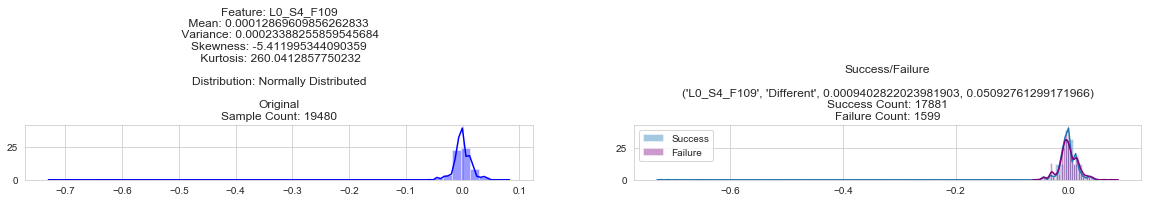

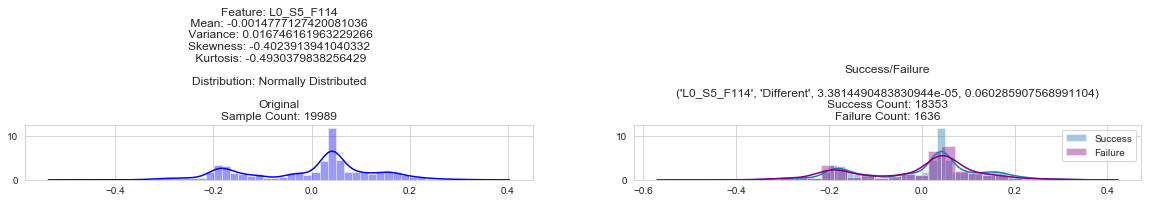

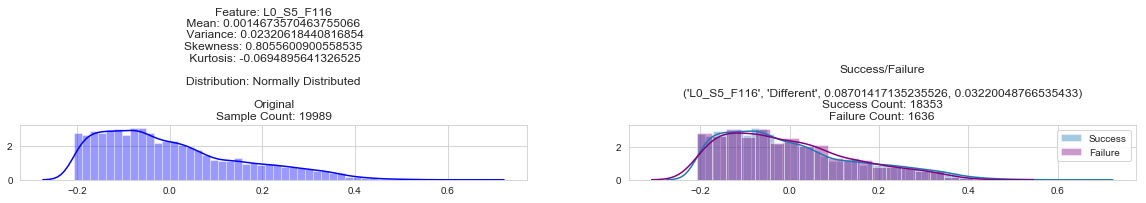

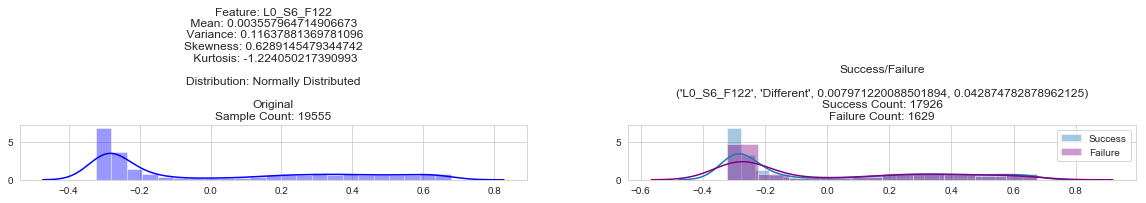

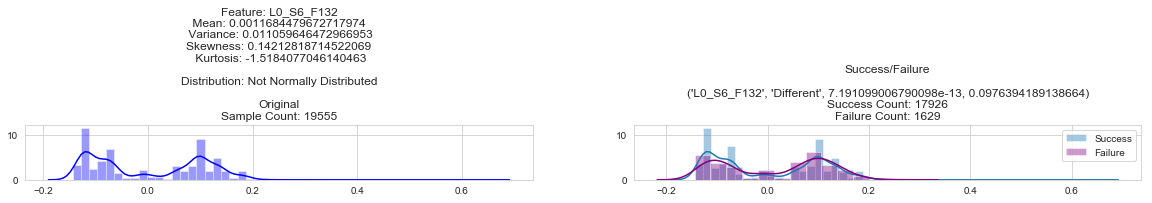

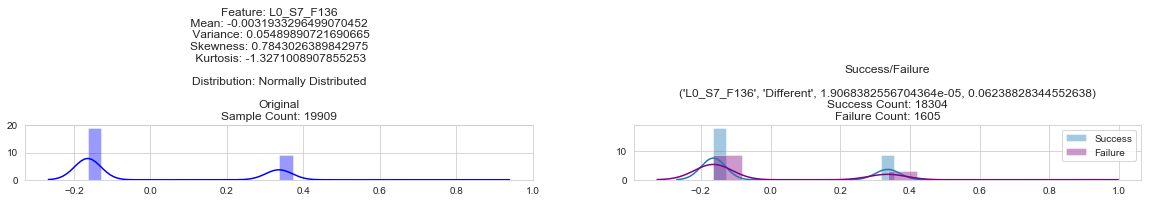

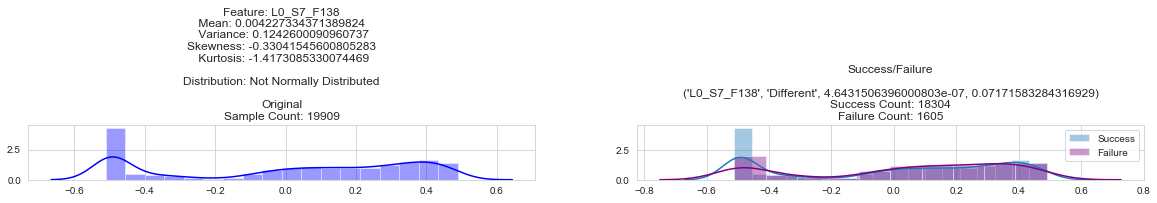

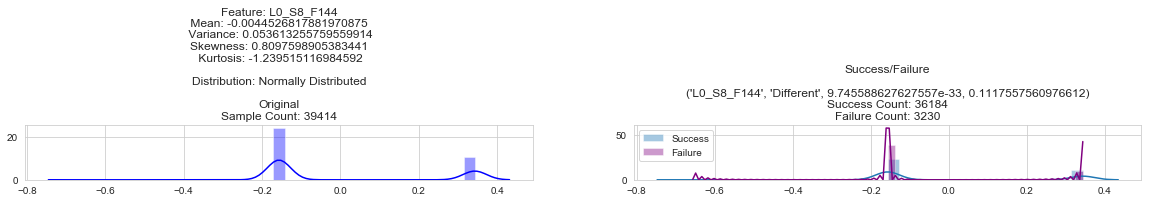

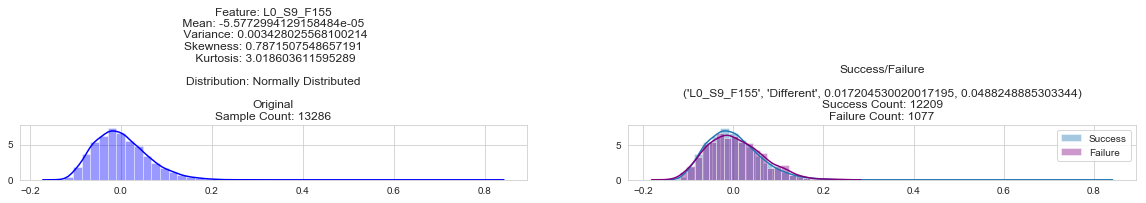

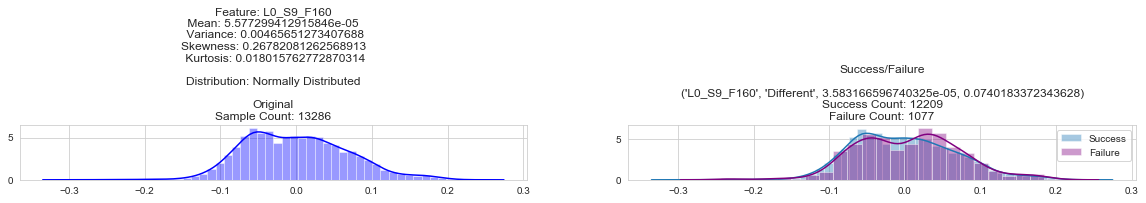

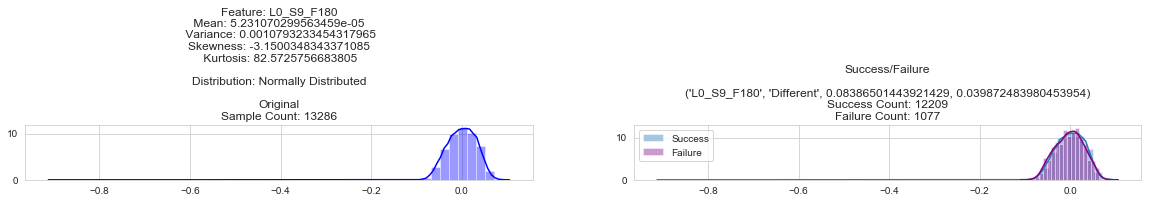

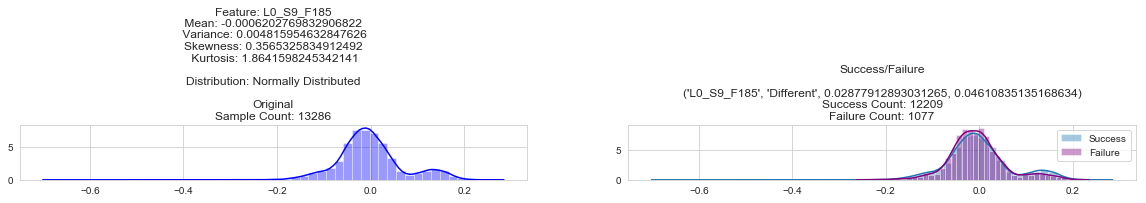

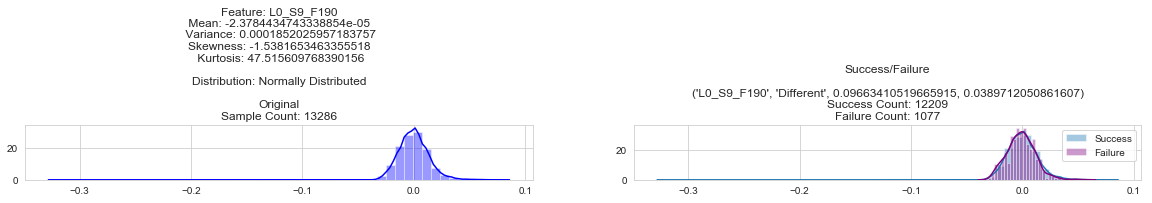

In [8]:
[plot_dist(mf_num_data,i,s_transformed[i]) for i in sig_diff_list[:30]];

<br><br><br>__Save sig_diff_list to be imported in Dimensionality Reduction:__

In [9]:
%store sig_diff_list

Stored 'sig_diff_list' (list)
